# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

1. Use the data provided, find the top 5 factors that are most highly correlated with the used car price

2. build a model to predict the price of the car
3. understand what are the non-essential information

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from warnings import filterwarnings 
filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge


In [2]:
car = pd.read_csv("data/vehicles.csv")

car.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [3]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [4]:
car=car.dropna()
car=car.drop(columns =['id', 'region', 'VIN', 'title_status', 'model'])

In [5]:
#print(' conditions are ', car['condition'].unique())
#print('fuel ', car['fuel'].unique())
#print('title', car['title_status'].unique())
#print('transmission	', car['transmission'].unique())

In [6]:

df=car.copy()  # save car copy

categorical_features =['manufacturer','condition','cylinders','fuel','transmission','drive','size','type','paint_color','state']
label_encoder = LabelEncoder()
for col in categorical_features:
    df[col] = label_encoder.fit_transform(df[col])
    


In [8]:
#Normalize the data 
scaler = StandardScaler()
df_scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled_data, columns=df.columns)
df_scaled.info()
df_scaled.head()
y=df_scaled['price']
X=df_scaled.drop('price', axis =1)
X.info()
### Now the data is scaled and normalized  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34868 entries, 0 to 34867
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         34868 non-null  float64
 1   year          34868 non-null  float64
 2   manufacturer  34868 non-null  float64
 3   condition     34868 non-null  float64
 4   cylinders     34868 non-null  float64
 5   fuel          34868 non-null  float64
 6   odometer      34868 non-null  float64
 7   transmission  34868 non-null  float64
 8   drive         34868 non-null  float64
 9   size          34868 non-null  float64
 10  type          34868 non-null  float64
 11  paint_color   34868 non-null  float64
 12  state         34868 non-null  float64
dtypes: float64(13)
memory usage: 3.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34868 entries, 0 to 34867
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year 

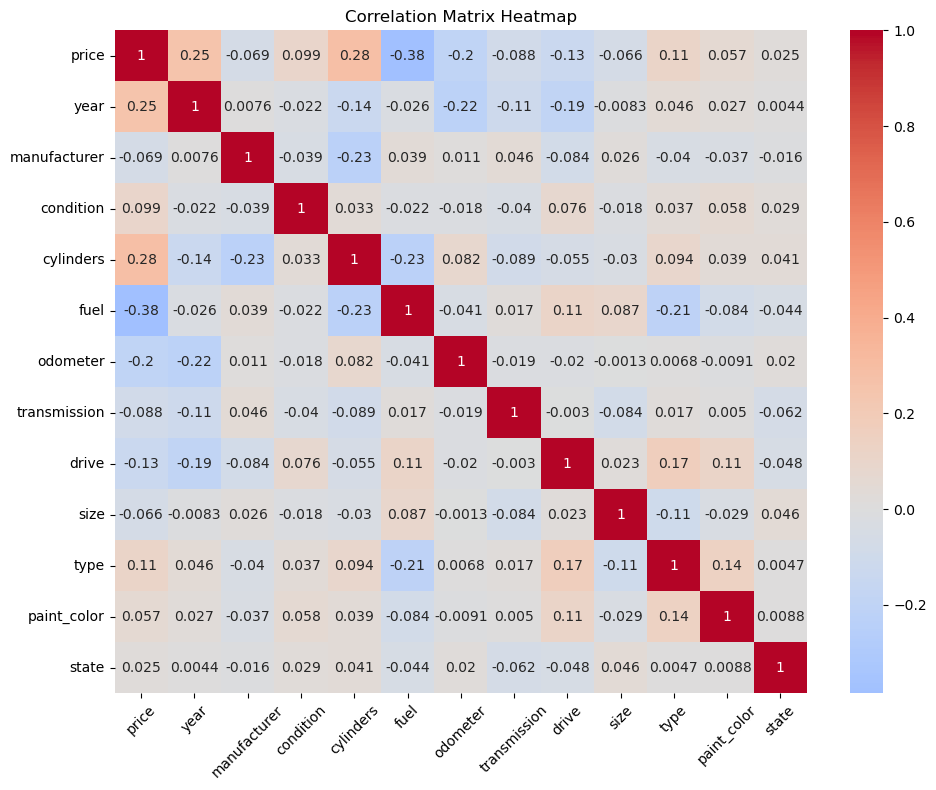

In [9]:

correlation_matrix =df_scaled.corr()
# Set up the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Customize the plot
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the heatmap
plt.show()






In [11]:

X_reduced =X.drop(columns=['paint_color', 'state', 'size', 'condition','transmission', 'manufacturer'])


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

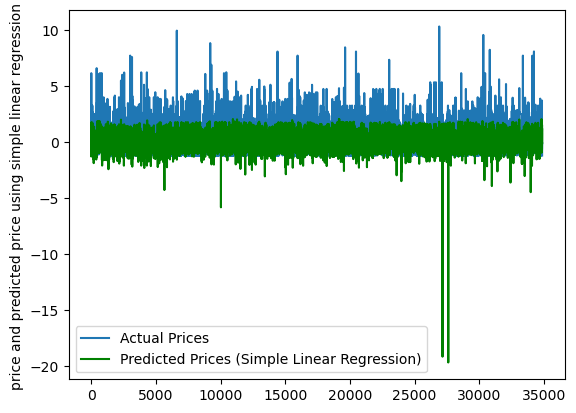

MSE for simple linear regression is  0.6927213092128666


In [12]:
### start with basic linear regression with the label encoding 

linreg = LinearRegression(fit_intercept=False).fit(X, y)
y_pred_lin1= linreg.predict(X)

plt.plot(y, label='Actual Prices')
plt.plot(y_pred_lin1, 'g', label='Predicted Prices (Simple Linear Regression)')

mse1_label_encoding= mean_squared_error(y, y_pred_lin1)
plt.ylabel('price and predicted price using simple linear regression ')
plt.legend()
plt.show()
print('MSE for simple linear regression is ',mse1_label_encoding)

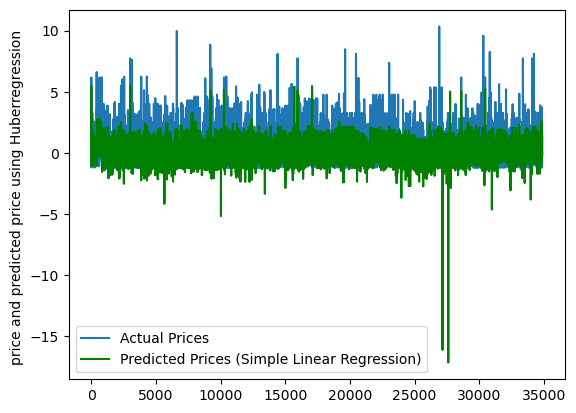

MSE for simple linear regression with onehot all feature is  0.5376287005796238
MSE for HuberRegressor with onehot all feature is  0.664362803007918


In [13]:
#try  onehot encoding and see if there is a difference
df_1 = pd.get_dummies(car.drop('price', axis = 1))
y1=y # same as car price scaled from before

scaler = StandardScaler()
df_scaled_data_1 = scaler.fit_transform(df_1)
X1 = pd.DataFrame(df_scaled_data_1, columns=df_1.columns)

all_features_linreg = LinearRegression(fit_intercept=False).fit(X1, y1)
y_pred_lin2= all_features_linreg.predict(X1)
linreg_mse2 = mean_squared_error(y_pred_lin2, y1)


# try Huber regressor

huber_all_features = HuberRegressor(fit_intercept=False).fit(X1, y1)
huber_mse = mean_squared_error(huber_all_features.predict(X1), y1)

plt.plot(y1, label='Actual Prices')
plt.plot(y_pred_lin2, 'g', label='Predicted Prices (Simple Linear Regression)')
plt.ylabel('price and predicted price using Huberregression ')
plt.legend()
plt.show()

print('MSE for simple linear regression with onehot all feature is ',linreg_mse2)
print('MSE for HuberRegressor with onehot all feature is ',huber_mse )

In [14]:
### now I know the encoding does have an effect. but we will use the label encoding and explore non-linear ters
# use the X and y for the label encoding

pipe = Pipeline([('quad_features', PolynomialFeatures(degree = 2)), ('quad_model', LinearRegression())])

pipe.fit(X, y)
quad_pipe_mse = float(mean_squared_error(y, pipe.predict(X)))

print('quad_pipe_mse is ', quad_pipe_mse)

quad_pipe_mse is  0.4927526158677545


In [23]:
pipe_3 = Pipeline([('deg_3_features', PolynomialFeatures(degree = 3)), ('deg_3_model', LinearRegression())])

pipe_3.fit(X, y)
deg_3_pipe_mse = float(mean_squared_error(y, pipe_3.predict(X)))
print('deg_3_pipe_mse', deg_3_pipe_mse )


polynomial_features_3 = pipe_3.named_steps['deg_3_features']

# Access the linear regression model inside the pipeline
linear_regression_model_3 = pipe_3.named_steps['deg_3_model']

# Get the coefficients of the linear regression model
coefficients_3 = linear_regression_model_3.coef_
polynomial_feature_names_3 = polynomial_features_3.get_feature_names_out()

# Find the indices of the top polynomial features based on their importance scores
top_feature_indices_3 = coefficients_3.argsort()[::-1]

# Specify the number of top features you want to consider
num_top_features = 10  # You can change this number as needed

# Print the top polynomial features and their corresponding coefficients
print("Top polynomial features:")
for i in range(num_top_features):
    feature_index = top_feature_indices_3[i]
    feature_name = polynomial_feature_names_3[feature_index]
    coefficient = coefficients_3[feature_index]
    print(f"{feature_name}: {coefficient}")


deg_3_pipe_mse 0.40514432583327065
Top polynomial features:
drive: 747083504.572302
drive^2: 587903919.1227665
transmission^2: 496479764.60953456
1: 7733325.856104568
year: 0.51309063614187
cylinders: 0.20220805445698378
condition^2: 0.1486637368798256
year^2: 0.12395177737501163
odometer type: 0.11052885465323925
odometer drive: 0.08547000866383314


In [24]:
# use the reduced featureset but with higher dim
mses = []
for i in range(1,7):
    pipe = Pipeline([('quad_features', PolynomialFeatures(degree = i, include_bias = False)), ('quad_model', LinearRegression())])
    pipe.fit(X_reduced, y)
    preds = pipe.predict(X_reduced)
    mse = mean_squared_error(y, preds)
    mses.append(mse)

print(len(mses))
print(np.round(mses, 2))

6
[0.7  0.55 0.51 0.49 0.46 0.42]


In [25]:


polynomial_features = pipe.named_steps['quad_features']

# Access the linear regression model inside the pipeline
linear_regression_model = pipe.named_steps['quad_model']

# Get the coefficients of the linear regression model
coefficients = linear_regression_model.coef_
polynomial_feature_names = polynomial_features.get_feature_names_out()

# Find the indices of the top polynomial features based on their importance scores
top_feature_indices = coefficients.argsort()[::-1]

# Specify the number of top features you want to consider
num_top_features = 10  # You can change this number as needed

# Print the top polynomial features and their corresponding coefficients
print("Top polynomial features:")
for i in range(num_top_features):
    feature_index = top_feature_indices[i]
    feature_name = polynomial_feature_names[feature_index]
    coefficient = coefficients[feature_index]
    print(f"{feature_name}: {coefficient}")




Top polynomial features:
year fuel: 183.15211156232237
year drive: 160.46827231936183
year drive^2: 121.2858700779711
fuel odometer drive^2 type^2: 104.70672245065781
year fuel type^2: 69.37909164088377
cylinders fuel odometer^2: 54.821398477807165
cylinders^2 fuel odometer type^2: 53.756639584152765
cylinders^2 fuel drive type^2: 52.43390603318785
cylinders fuel drive^2 type: 47.972703670494184
fuel odometer^2: 44.602628589114275


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [20]:
##cross-validation with Ridge and GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
params_dict = {'alpha': [0.1, 1.0, 10.0,100]}
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid=params_dict)
grid.fit(X_train, y_train)
train_preds = grid.predict(X_train)
test_preds = grid.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
print(f'Train MSE: {train_mse: .2f}')
print(f'Test MSE: {test_mse: .2f}')


Train MSE:  0.70
Test MSE:  0.67


In [22]:
##cross-validation

selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=4)
pipe_4 = Pipeline([('column_selector', selector),
                ('linreg', LinearRegression())])
pipe_4.fit(X_train, y_train)
train_preds_4 = pipe.predict(X_train)
test_preds_4 = pipe.predict(X_test)
train_mse_4 = mean_squared_error(y_train, train_preds_4)
test_mse_4 = mean_squared_error(y_test, test_preds_4)

print(f'Train MSE: {train_mse_4: .2f}')
print(f'Test MSE: {test_mse_4: .2f}')


Train MSE:  0.50
Test MSE:  0.47


 ### The LinearRegression model still works better than Ridge.  This cross-validation and earlier experiments both showed for a reasonably small sized model, we can have MSE to be around 0.4-0.5. 

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

# Summary of Findings

 The top factors that driive the used car price are: Fuel, cylinder and year, then drive.  
    We have performed the analysis with different modeling techniques such linearregression, ridge, CVGridsearch, cross-validation.  In addition to identify the top factors. We can also predict the used car price  with over 60% confidence.  The top features and relative weight to predict the price are listed as below
           
year * fuel:    183.15211156232237
year * drive:   160.46827231936183
year * drive^2: 121.2858700779711
fuel odometer * drive^2 *type^2: 104.70672245065781
year * fuel* type^2:  69.37909164088377
cylinders *fuel *odometer^2: 54.821398477807165
cylinders^2 * fuel *odometer *type^2: 53.756639584152765
cylinders^2* fuel* drive *type^2: 52.43390603318785
cylinders *fuel* drive^2 *type: 47.972703670494184
fuel *odometer^2: 44.602628589114275
      
### Next steps and recommendations:
   1. To find cars with higher price, 
      the year of the car, and fuel, and drive, cyclinder are the key things to look for when selecting a car.  
   2. One area that was counter-intuitive in this result is that the brand of the car did not seem to have much impact on the price.  I suspect that this is because that the manufacturer and model are difficult to translate to numerical values. As a next step, it is worth testing is to add a new parameter such as orignal price to capture that information of the car's brand/model (hence original value).
   


# Appendix of the report
## Detailed technical explanation of the analysis 
  The section and below is an attachment of technical details for the data Scientist department who want to understand what the analysis was and how the results are concluded

1. since we have a large amount of non-numerical features,  we first evaluate the results from two different encoding 
  a. the label encoding
  b. the one-hot encoding
  
2.  Using the basic linear model, the one hot encoding with all the features produced slightly better results than the same basic linear model with label encoding
    MSE for simple linear regression with label encoding is  0.6927213092128666
     MSE for simple linear regression with onehot all feature is  0.5376287005796238

    I also explored simple linear regression vs Huberregression, 
      MSE for HuberRegressor with onehot all feature is  0.664362803007918

3.  Explore polynomial features 

For polynomial feature, to make apples to apples comparison.  I stick to the label encoding to keep the number of features manageable.
   MSE for simple linear regression with label encoding is  0.6927213092128666
   degree =2,   quad_pipe_mse is  0.4927526158677545
   Degree =3,  deg_3_pipe_mse 0.40514432583327065
for degree =3,  Top polynomial features:
drive: 747083504.572302
drive^2: 587903919.1227665
transmission^2: 496479764.60953456
1: 7733325.856104568
year: 0.51309063614187
cylinders: 0.20220805445698378
condition^2: 0.1486637368798256
year^2: 0.12395177737501163
odometer type: 0.11052885465323925
odometer drive: 0.08547000866383314

4.  use reduced feature list for higher order polynomial
  By looking at the correlation matrix, I dropped off the features that are least correlated with price.  this provided a short list of features to allow me to do the higher order polynomial features.  I ran the reduced data set with 1-7 degrees.  and found out the 
  MSES =[0.7  0.55 0.51 0.49 0.46 0.42]   it gets smaller as the degress increses, but started falttern around 4-5.  We will still use degree =6 as the best model
  
  the top features are
   
year fuel: 183.15211156232237
year drive: 160.46827231936183
year drive^2: 121.2858700779711
fuel odometer drive^2 type^2: 104.70672245065781
year fuel type^2: 69.37909164088377
cylinders fuel odometer^2: 54.821398477807165
cylinders^2 fuel odometer type^2: 53.756639584152765
cylinders^2 fuel drive type^2: 52.43390603318785
cylinders fuel drive^2 type: 47.972703670494184
fuel odometer^2: 44.602628589114275

4.  We then crossvalidated by split the dataset with training and testing set
 We tested with both the Ridgemodel and the sequentialselctor using linear regression
 the Selector with linear regression performance better 
